In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

sns.set()

from IPython.display import display
from tools import make_track, ols_regression, make_ER, lasso_regression, lasso_regression_ic, ridge_regression, kalman_filter
from hc_graph import hc_stock

<IPython.core.display.Javascript object>

Open console to check js libs were loaded in page


### Financial data loads and cleaning

In [3]:
# US rate
fund_name = 'HFRXSDV'
US_rate = pd.read_csv(r"financial_data/USD_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['3M']

# HFRX
hfrx_all = pd.read_csv(r"financial_data/hfrx_daily_index_data.csv", index_col=0, parse_dates=True, dayfirst=True).ffill()
hfrx = make_ER(hfrx_all[[fund_name]].dropna(), US_rate)

# BNP

bnp = pd.read_csv(r"financial_data/bnp_data.csv", index_col=0, parse_dates=True, dayfirst=True) #[["BNPIFEU","BNPIFUS",
                 #"BNPIFJP","BNPIFCN","BNPIFFR","BNPIFGE","BNPIFGB","BNPIFCH","BNPIFKR","BNPIFUSC","BNPIFBR",
                 #"BNPIFAU","BNPIFHK","BNPIFTW","BNPIFSG","BNPIFIT","BNPIFSP","BNPIFSW","BNPIFNE","BNPIFRU","BNPIFEM"]]

risk_premia = pd.read_pickle("financial_data/risk_premia_ER_FX_USD.pkl") #[["BNPICCE3","BNPIVMRU","BNPIAIRT","BNPIAIRU",
                  #"BNPIEC03","BNPIPLEE","BNPIPMEE","BNPIPQEE","BNPIPVEE","BNPILUEE","BNPIPMUH","BNPIPQUH",
                  #"BNPIPVUH","BNPIAIRG","BNPIAIRJ","BNPIAIRE"]]

In [4]:
prices_all = bnp.join(risk_premia,how="outer").ffill().bfill().join(hfrx,how="inner")

In [5]:
returns_all = prices_all.resample('1D').first().pct_change().dropna()
hrfx_returns = returns_all[[fund_name]]
returns_all = returns_all.drop(fund_name, axis=1)

In [6]:
size = 126
freq = 5

c:\program files (x86)\python36-32\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 58 iterations, i.e. alpha=1.726e-02, with an active set of 56 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
c:\program files (x86)\python36-32\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 60 iterations, i.e. alpha=1.628e-02, with an active set of 58 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
c:\program files (x86)\python36-32\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 68 iterations, i.e. alpha=1.300e-02, with an active set of 64 regress

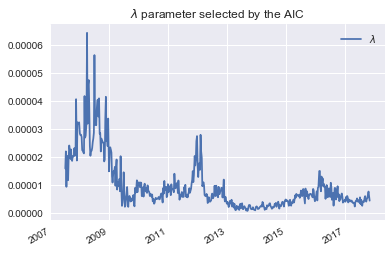

Wall time: 42.9 s


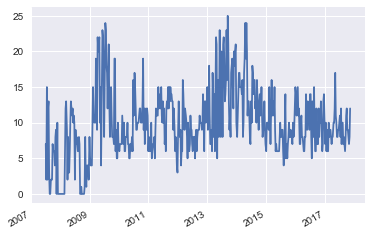

In [7]:
%%time
df_weight_aic = lasso_regression_ic(hrfx_returns, returns_all,sample_length=size, frequency=freq, criterion='aic')
prices_for_track_all = prices_all.loc[df_weight_aic.index[0]:].drop(fund_name, axis=1)
replication_all = make_track(prices_for_track_all, df_weight_aic)

df_res = prices_all.loc[replication_all.index][[fund_name]]
df_res["Lasso AIC"] = replication_all
(df_weight_aic != 0).sum(axis=1).plot()

c:\program files (x86)\python36-32\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 58 iterations, i.e. alpha=1.726e-02, with an active set of 56 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
c:\program files (x86)\python36-32\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 60 iterations, i.e. alpha=1.628e-02, with an active set of 58 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
c:\program files (x86)\python36-32\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 68 iterations, i.e. alpha=1.300e-02, with an active set of 64 regress

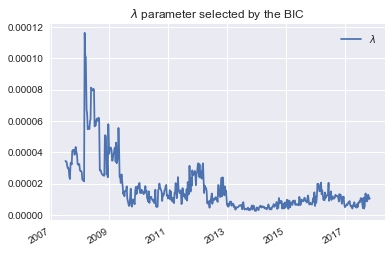

Wall time: 42.2 s


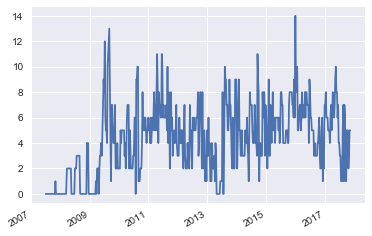

In [8]:
%%time
df_weight_bic = lasso_regression_ic(hrfx_returns, returns_all,sample_length=size, frequency=freq, criterion='bic')
prices_for_track_all = prices_all.loc[df_weight_bic.index[0]:].drop(fund_name, axis=1)
replication_all = make_track(prices_for_track_all, df_weight_bic)

df_res["Lasso BIC"] = replication_all
(df_weight_bic != 0).sum(axis=1).plot()

In [9]:
%%time
nu = 1.
df_weight_kalman = kalman_filter(hrfx_returns, returns_all,freq, sigma_weight=nu*0.1 , sigma_return=0.1)

prices_for_track_kalman = prices_all.loc[df_weight_kalman.index[0]:]
replication_kalman = make_track(prices_for_track_kalman, df_weight_kalman).loc[df_res.index[0]:]
df_res["Kalman"] = replication_kalman

Wall time: 9.66 s


In [10]:
df_res = df_res.loc['2009':]
df_res = (df_res/df_res.iloc[0])

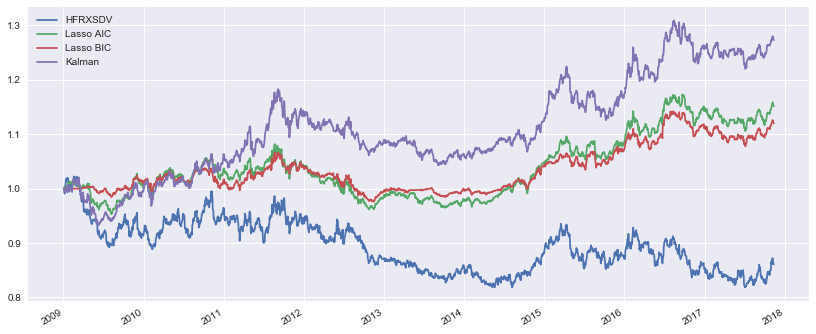

In [11]:
df_res.plot(figsize=(14,6))

In [12]:
df_res.pct_change().corr(method="pearson")

,HFRXSDV,Lasso AIC,Lasso BIC,Kalman
HFRXSDV,1.000000,0.618441,0.570156,0.659547
Lasso AIC,0.618441,1.000000,0.929402,0.821875
Lasso BIC,0.570156,0.929402,1.000000,0.757456
Kalman,0.659547,0.821875,0.757456,1.000000


In [13]:
returns_track = df_res.pct_change().dropna()
feu = returns_track[fund_name]
returns_track = returns_track.drop(fund_name, axis=1)
df = pd.DataFrame()
df['Tracking error'] = (returns_track.T - feu.values).std(axis=1)
df['R-squared'] = 1 - (returns_track.T - feu.values).var(axis=1) / feu.values.var()
df

,Tracking error,R-squared
Lasso AIC,0.003821,0.380828
Lasso BIC,0.004034,0.309698
Kalman,0.003680,0.425525


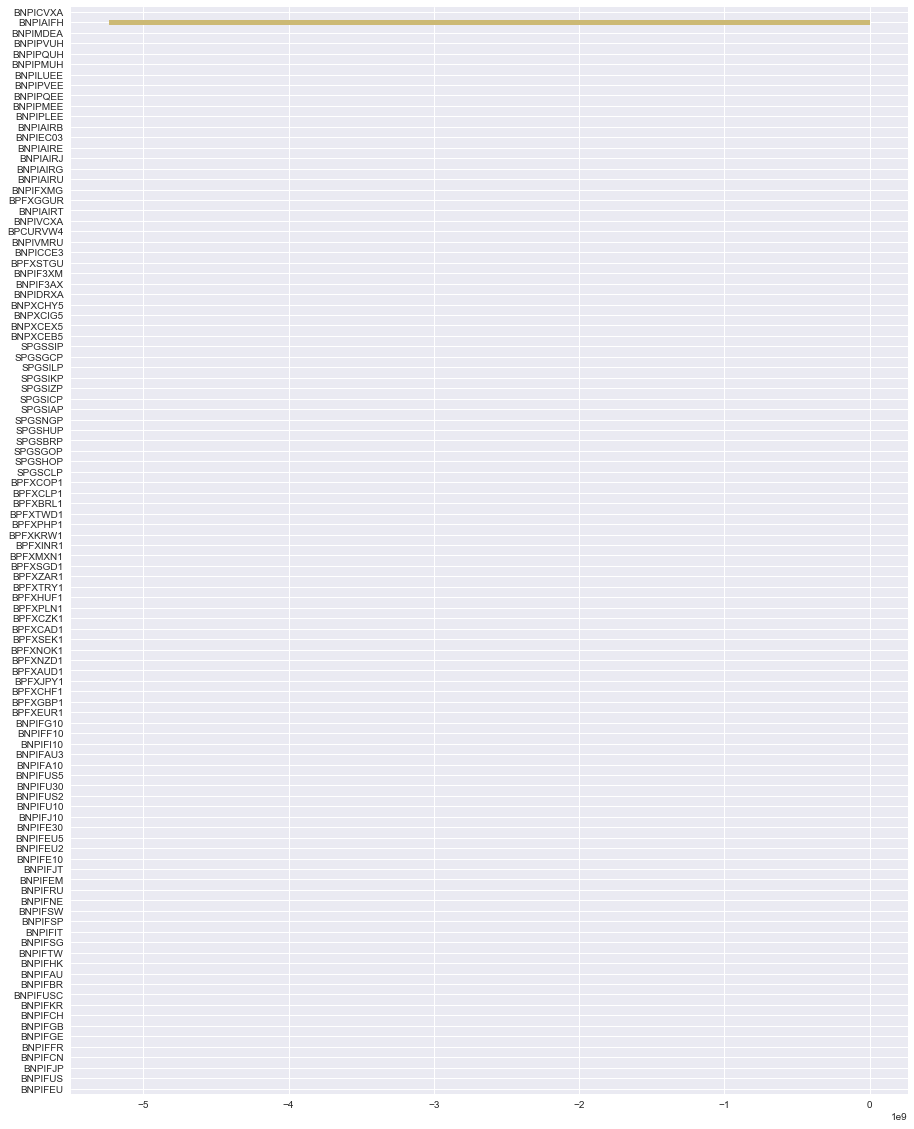

In [14]:
(df_weight_aic.loc['2009':]).mean(axis=0).plot(kind='barh', figsize=(15,20))

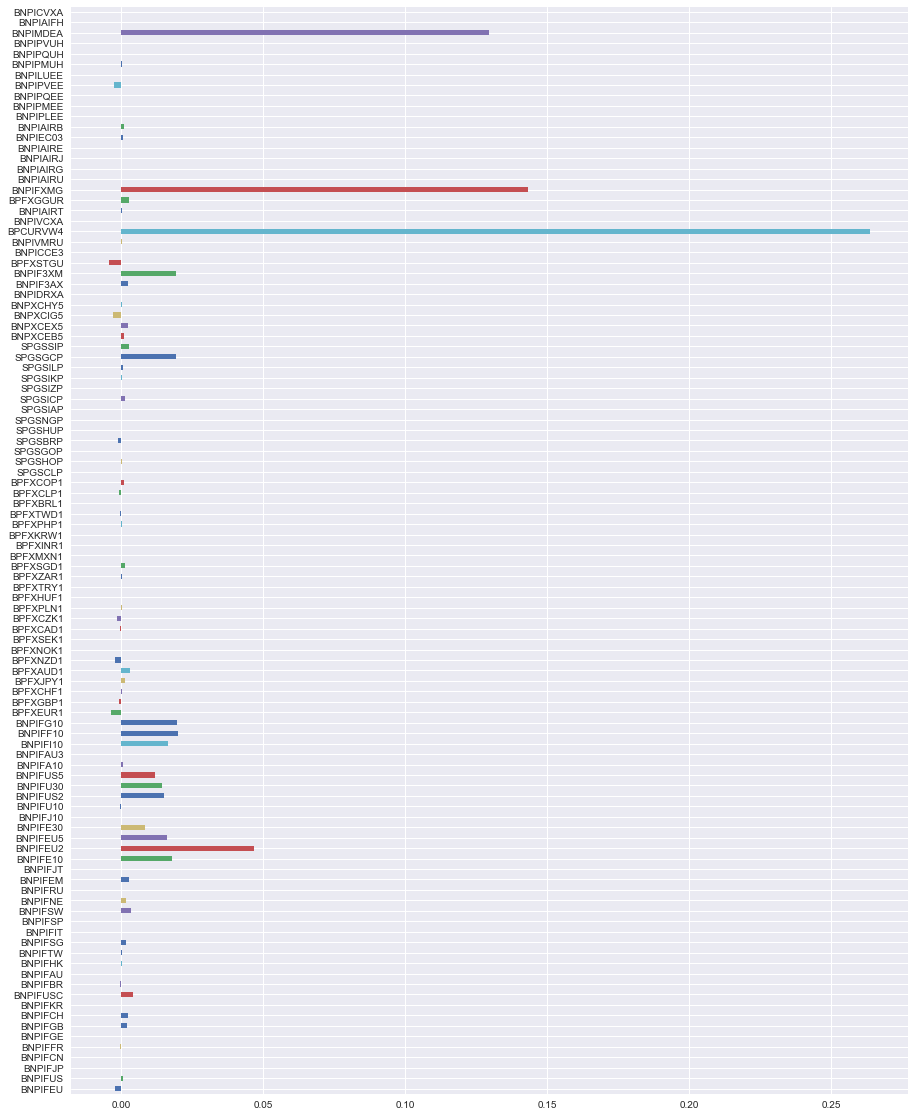

In [15]:
(df_weight_bic.loc['2009':]).mean(axis=0).plot(kind='barh', figsize=(15,20))

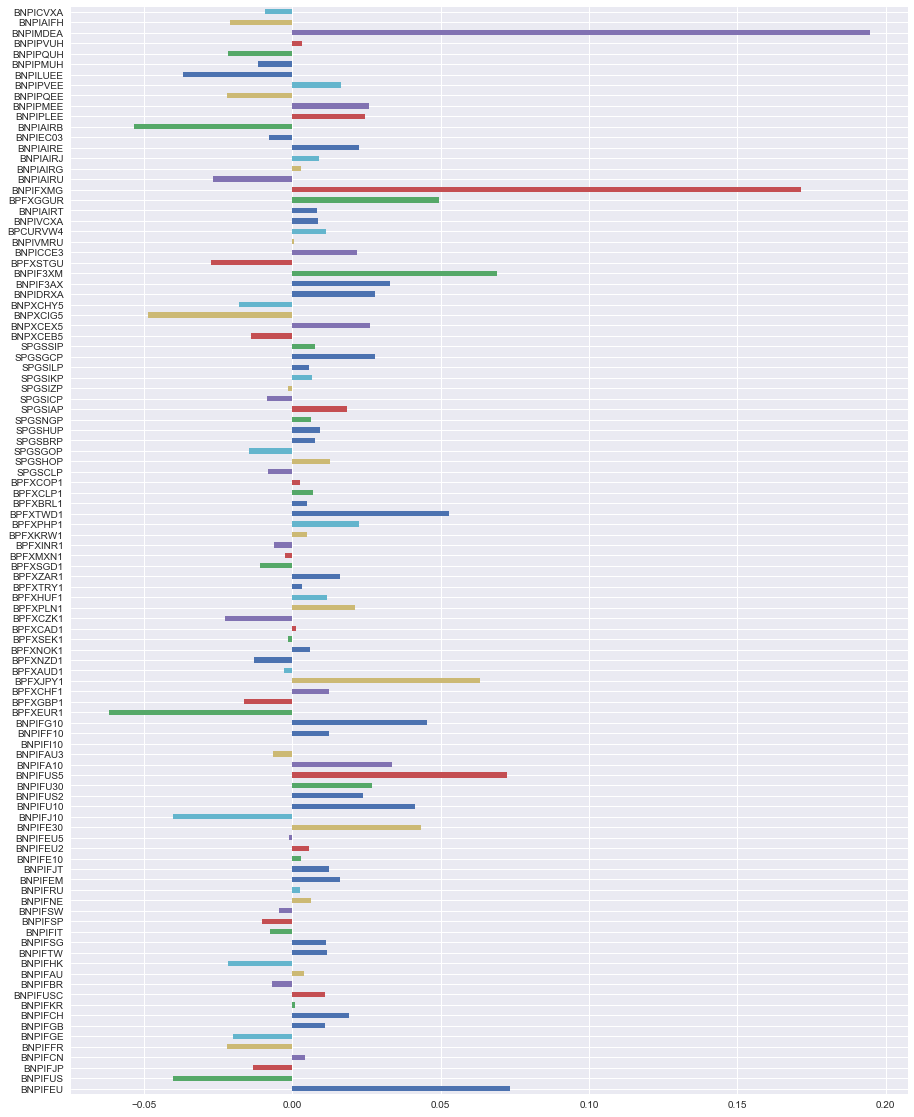

In [16]:
df_weight_kalman.loc[df_res.index[0]:].mean(axis=0).plot(kind='barh', figsize=(15,20))

In [18]:
df_res[fund_name].pct_change().autocorr(lag=1)

0.039414238387560641

In [19]:
df_res['Kalman'].pct_change().autocorr(lag=1)

0.10555322222377118

In [20]:
df_res['Lasso AIC'].pct_change().autocorr(lag=1)

0.097976449660376178